# Check of the NOE quantitative reliability

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from functions import *

plt.rcParams['figure.dpi'] = 300

In [2]:
pdb_ids = ['2LEA', '2K52', '2LTM', '2KD0', '2LF2']
pdb_id = pdb_ids[0]

## Reading the individual 3D $^{15}N$-NOESY peak lists

In [3]:
path = f'~/Sparky/Lists/{pdb_id}.list' # set correctly

# Reading the data
df = pd.read_csv(path, header=0, index_col=None, sep='\s+')
df = tidy_list(df)

# Why do we have negative NOEs? 
# Anyway, the phase is not important for this analysis, just remove the sign
df['height'] = np.abs(df.height)

df

,res,noe,N,Hn,H,height,noe_res,inter,resnum,noe_resnum,res_diff,atom_type,atom_type_pos
0,S1,H,116.240,8.111,8.111,1571,S1,False,1,1,0,H,H_i
1,S1,HA,116.240,8.111,4.389,1756,S1,False,1,1,0,HA,HA_i
2,S1,HB2,116.240,8.111,3.750,2457,S1,False,1,1,0,HB,HB_i
3,S1,HB3,116.240,8.111,3.750,2457,S1,False,1,1,0,HB,HB_i
4,S1,Y2H,116.240,8.111,8.062,554,Y2,True,1,2,-1,H,H_i+1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1789,S100,H99HB3,123.154,8.119,3.245,1350,S100,False,100,100,0,H,H_i
1790,S100,H,123.154,8.119,8.119,69967,S100,False,100,100,0,H,H_i
1791,S100,HA,123.154,8.119,4.258,2956,S100,False,100,100,0,HA,HA_i
1792,S100,HB2,123.154,8.119,3.849,3318,S100,False,100,100,0,HB,HB_i


Removing the side-chains

In [4]:
df = df.loc[~ (df.res.str.contains('ND') | df.res.str.contains('NE'))]

Remove the backbone-to-sidechain contacts (they are too intense or just overlapped)

In [5]:
df = df.loc[~ (df.noe.str.contains('HG') | df.noe.str.contains('HD') | df.noe.str.contains('HE'))]

Removing the diagonals

In [6]:
df = df.query('Hn != H')

In [7]:
df.shape

(1161, 13)

# Analysis

### Intensity distribution

<Axes: ylabel='Frequency'>

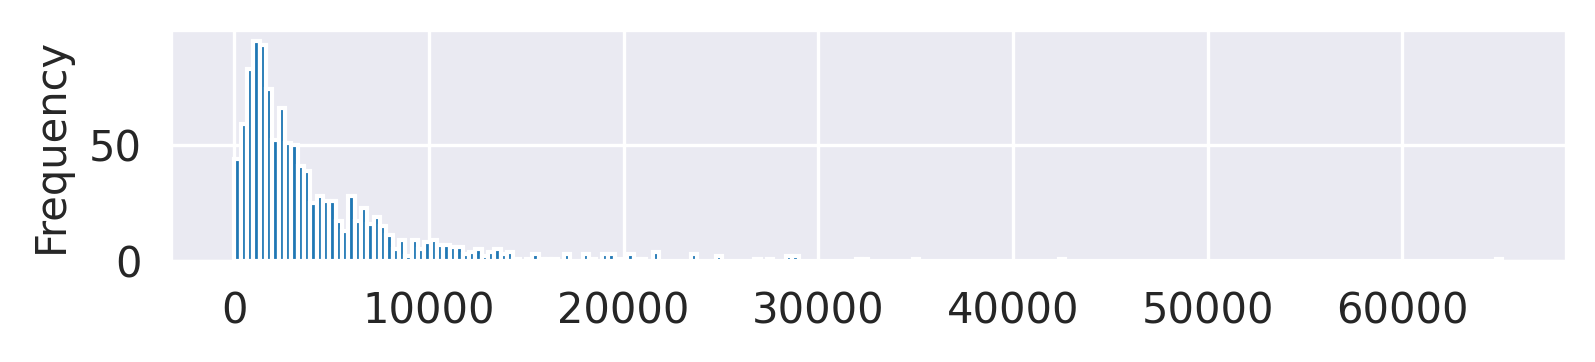

In [84]:
df.height.plot(kind='hist', figsize=(6,1), bins=200)

In [8]:
get_atom_rank_matrix(df, exclude_sc=True)

,1st highest,2nd highest,3rd highest,4th or lower
Atom name,,,,
HA_i,30,38,20,5
HA_i-1,41,14,10,25
H_i-1,7,15,18,43


In [9]:
get_atoms_w_strongest_noes(df)

,count
Atom type,
HA_i-1,35
HB_i,23
HA_i,9
HB_i-1,6
H_i+1,4
H_i-1,4
H_i-2,2
H_i+2,2
HA_i-2,2


> It would be also useful the see for each of the HA_i, HA_i-1, H_i-1 the following numbers:

> - average relative intensity with respect to the spin system's maximum intensity
> - minimum relative intensity
> - the frequencies you computed above but considering only HN protons
> - the frequencies you computed above but considering only HA protons

Intenities only among HN peaks

In [10]:
df_hn = df.loc[df.atom_type == "H"]
get_atom_rank_matrix(df_hn) #, exclude_sc=True) - obsolete since the df is already filtered for amide protons

,1st highest,2nd highest,3rd highest,4th or lower
Atom name,,,,
H_i-1,44,29,6,4


In [11]:
df_ha = df.loc[df.atom_type == "HA"]
get_atom_rank_matrix(df_ha)  

,1st highest,2nd highest,3rd highest,4th or lower
Atom name,,,,
HA_i,43,34,14,2
HA_i-1,44,25,19,2


In [55]:
df_to_plot = df.loc[df['atom_type_pos'].isin(["H_i-1", "HA_i-1", "HA_i"])][['res', 'height', 'atom_type_pos']]#.set_index('res')

df_to_plot = pd.concat([df_hn_im1, df_ha_im1, df_ha], axis=0)
df_to_plot['atom_type_pos'] = df_to_plot['atom_type_pos'].replace({'H_i-1': '$H_{i-1}$', 'HA_i-1': '$H^A_{i-1}$', 'HA_i': '$H^A_{i}$'})

df_to_plot

,res,height,atom_type_pos
5,Y2,8140,$H_{i-1}$
16,G3,521,$H_{i-1}$
25,R4,1553,$H_{i-1}$
49,V9,8153,$H_{i-1}$
64,E10,11217,$H_{i-1}$
...,...,...,...
1757,G92,848,$H^A_{i}$
1758,G92,457,$H^A_{i}$
1764,R93,7823,$H^A_{i}$
1776,S97,2611,$H^A_{i}$


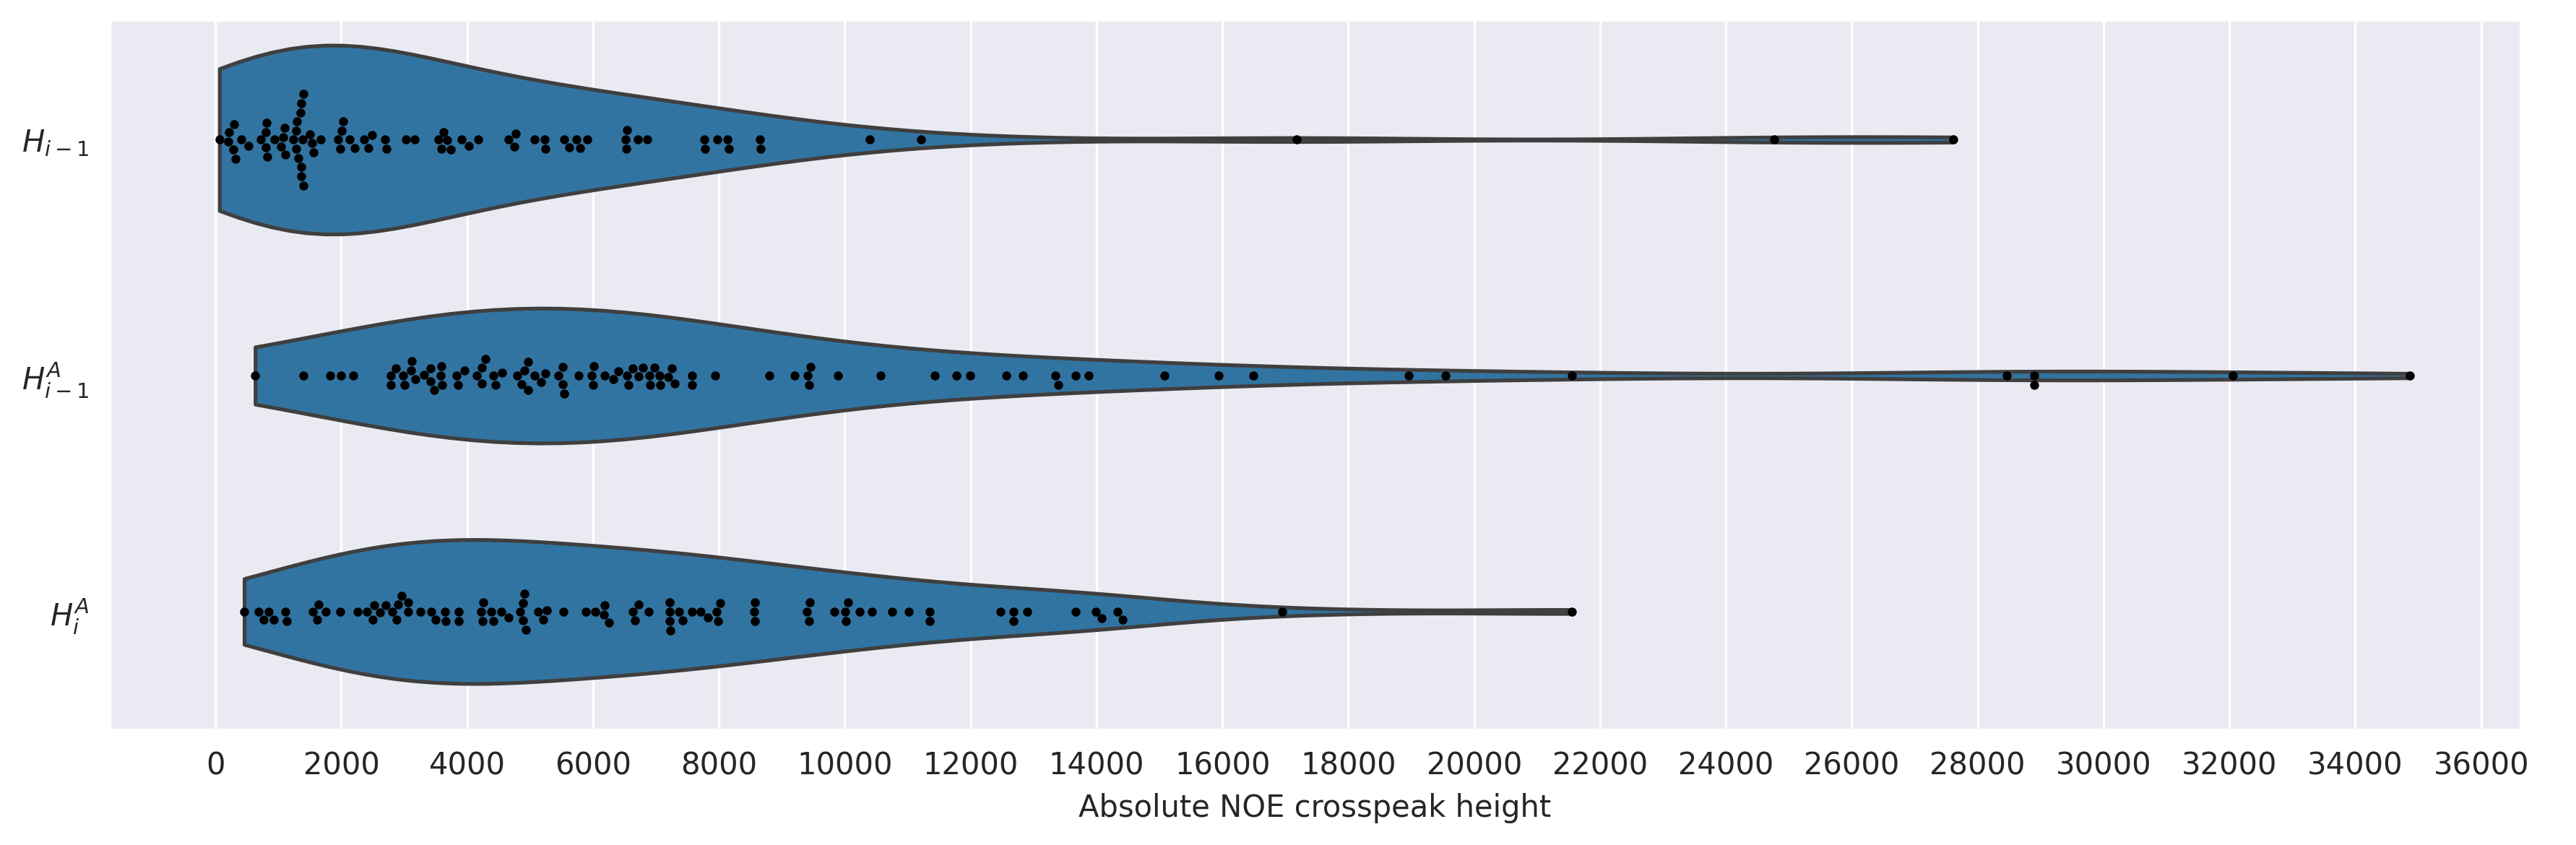

In [81]:
g = sns.catplot(data=df_to_plot, x="height", y="atom_type_pos", kind="violin", inner=None, aspect=3, height=4, cut=0)
sns.swarmplot(data=df_to_plot, x="height", y="atom_type_pos", color="k", size=3, ax=g.ax)
g.ax.xaxis.set_major_locator(plt.MaxNLocator(20))

plt.ylabel(None)
plt.xlabel("Absolute NOE crosspeak height");

Which crosspeaks are almost 0?

In [78]:
df_to_plot.loc[df_to_plot.height<1000]

,res,height,atom_type_pos
16,G3,521,$H_{i-1}$
127,L15,802,$H_{i-1}$
316,Y22,204,$H_{i-1}$
332,R23,285,$H_{i-1}$
701,G40,817,$H_{i-1}$
829,R48,320,$H_{i-1}$
908,S53,806,$H_{i-1}$
924,R54,720,$H_{i-1}$
1050,R60,820,$H_{i-1}$
1484,D80,410,$H_{i-1}$


In [14]:
df.res.unique().shape

(91,)

### Average intensities in the spin systems

In [121]:
dff = df[['res', 'atom_type_pos', 'height']]
mean_height = df[['res', 'height']].groupby('res').transform('max')
dff.loc[:, 'height'] = dff['height'].astype('float')
dff.loc[:,'height'] = dff['height'].astype('float64') / mean_height['height'].astype('float64')

dff

/tmp/ipykernel_120133/747429716.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.71469271 1.         1.         ... 0.89089813 1.         1.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dff.loc[:,'height'] = dff['height'].astype('float64') / mean_height['height'].astype('float64')


,res,atom_type_pos,height
1,S1,HA_i,0.714693
2,S1,HB_i,1.000000
3,S1,HB_i,1.000000
4,S1,H_i+1,0.225478
5,Y2,H_i-1,0.609692
...,...,...,...
1788,S100,H_i,0.513864
1789,S100,H_i,0.406872
1791,S100,HA_i,0.890898
1792,S100,HB_i,1.000000


In [122]:
dff_to_plot = dff.loc[df['atom_type_pos'].isin(["H_i-1", "HA_i-1", "HA_i"])][['res', 'height', 'atom_type_pos']]
dff_to_plot['atom_type_pos'] = dff_to_plot['atom_type_pos'].replace({'H_i-1': '$H_{i-1}$', 'HA_i-1': '$H^A_{i-1}$', 'HA_i': '$H^A_{i}$'})

/home/katja/PycharmProjects/NOESY_3D/.venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 16.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/katja/PycharmProjects/NOESY_3D/.venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 18.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


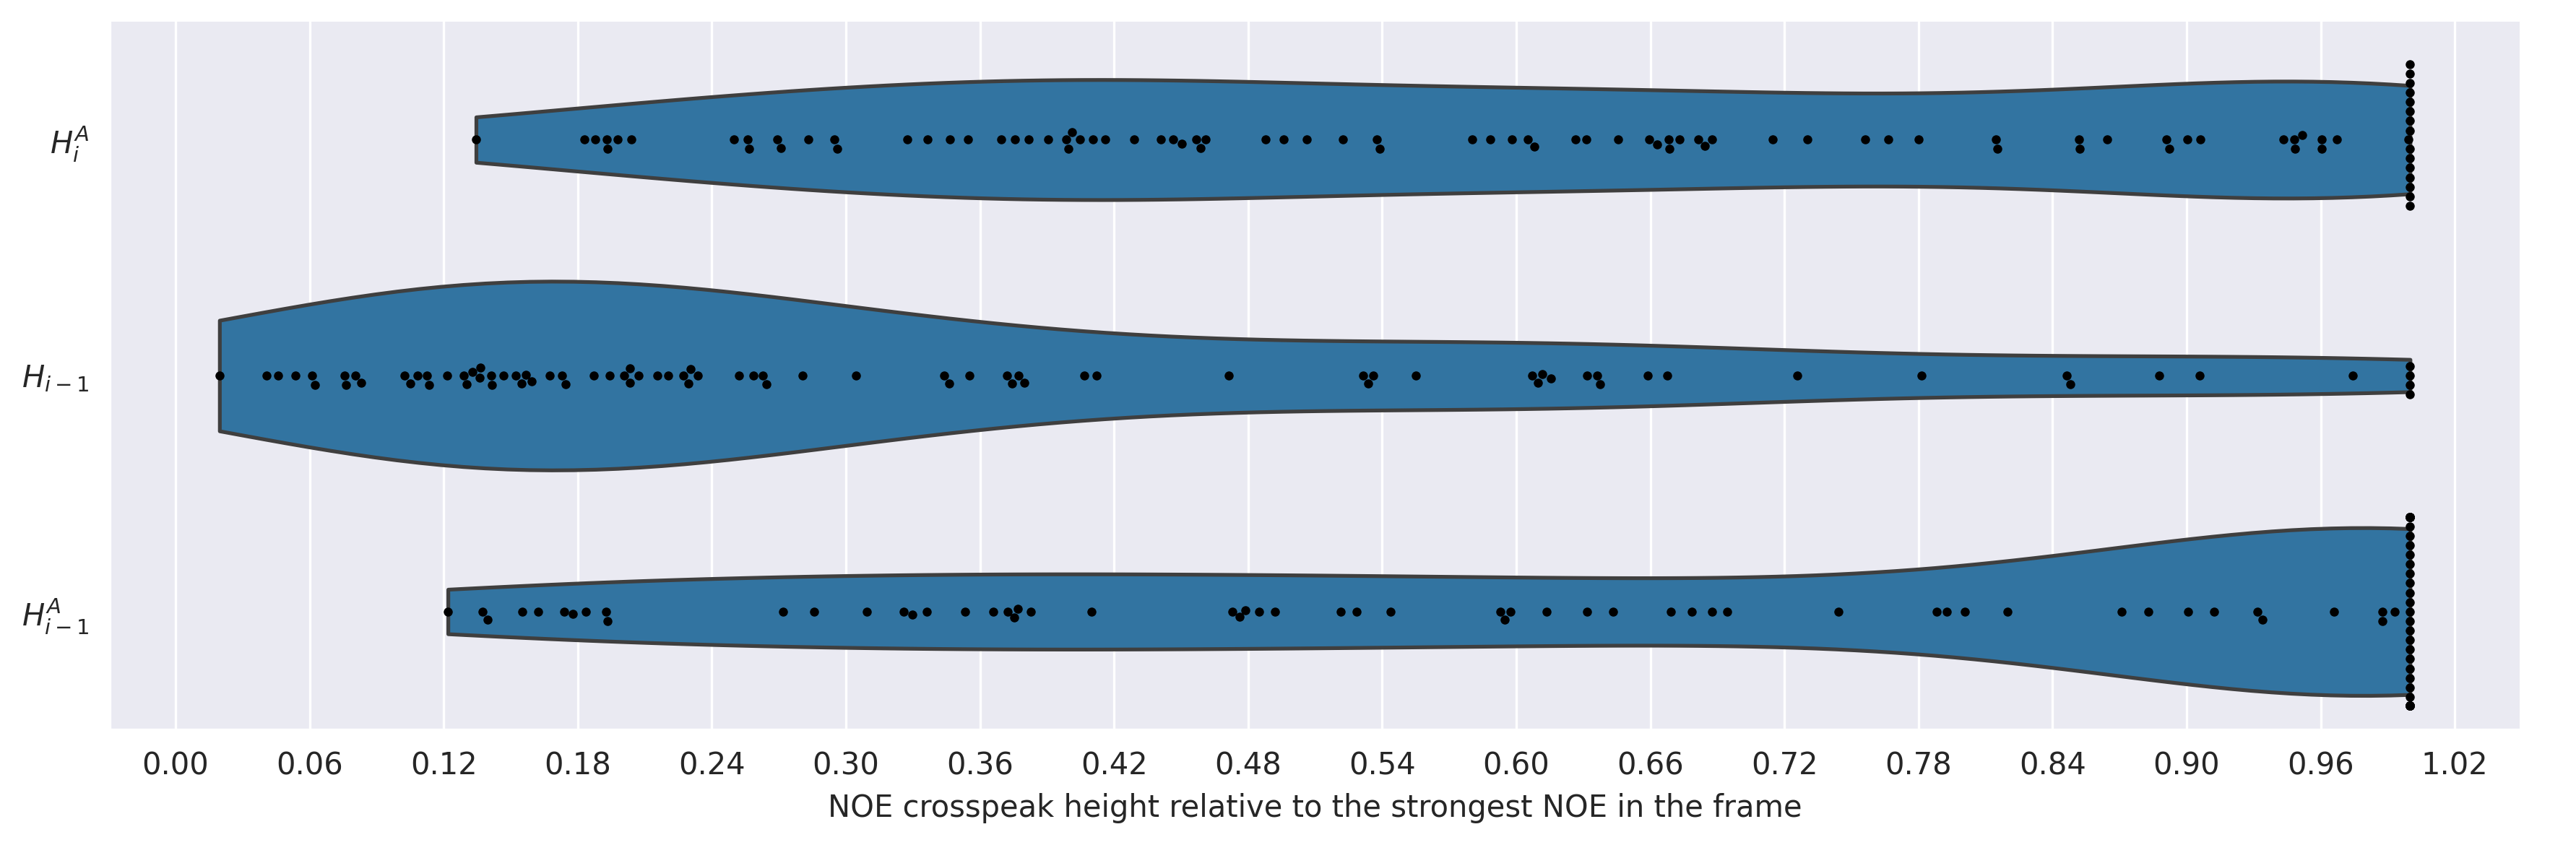

In [130]:
gf = sns.catplot(data=dff_to_plot, x="height", y="atom_type_pos", kind="violin", inner=None, aspect=3, height=4, cut=0)
sns.swarmplot(data=dff_to_plot, x="height", y="atom_type_pos", color="k", size=3, ax=gf.ax)
gf.ax.xaxis.set_major_locator(plt.MaxNLocator(20))

plt.ylabel(None)
plt.xlabel("NOE crosspeak height relative to the strongest NOE in the frame");

In [149]:
for k, g in dff_groups:
    print(k)

$H^A_{i-1}$
$H^A_{i}$
$H_{i-1}$


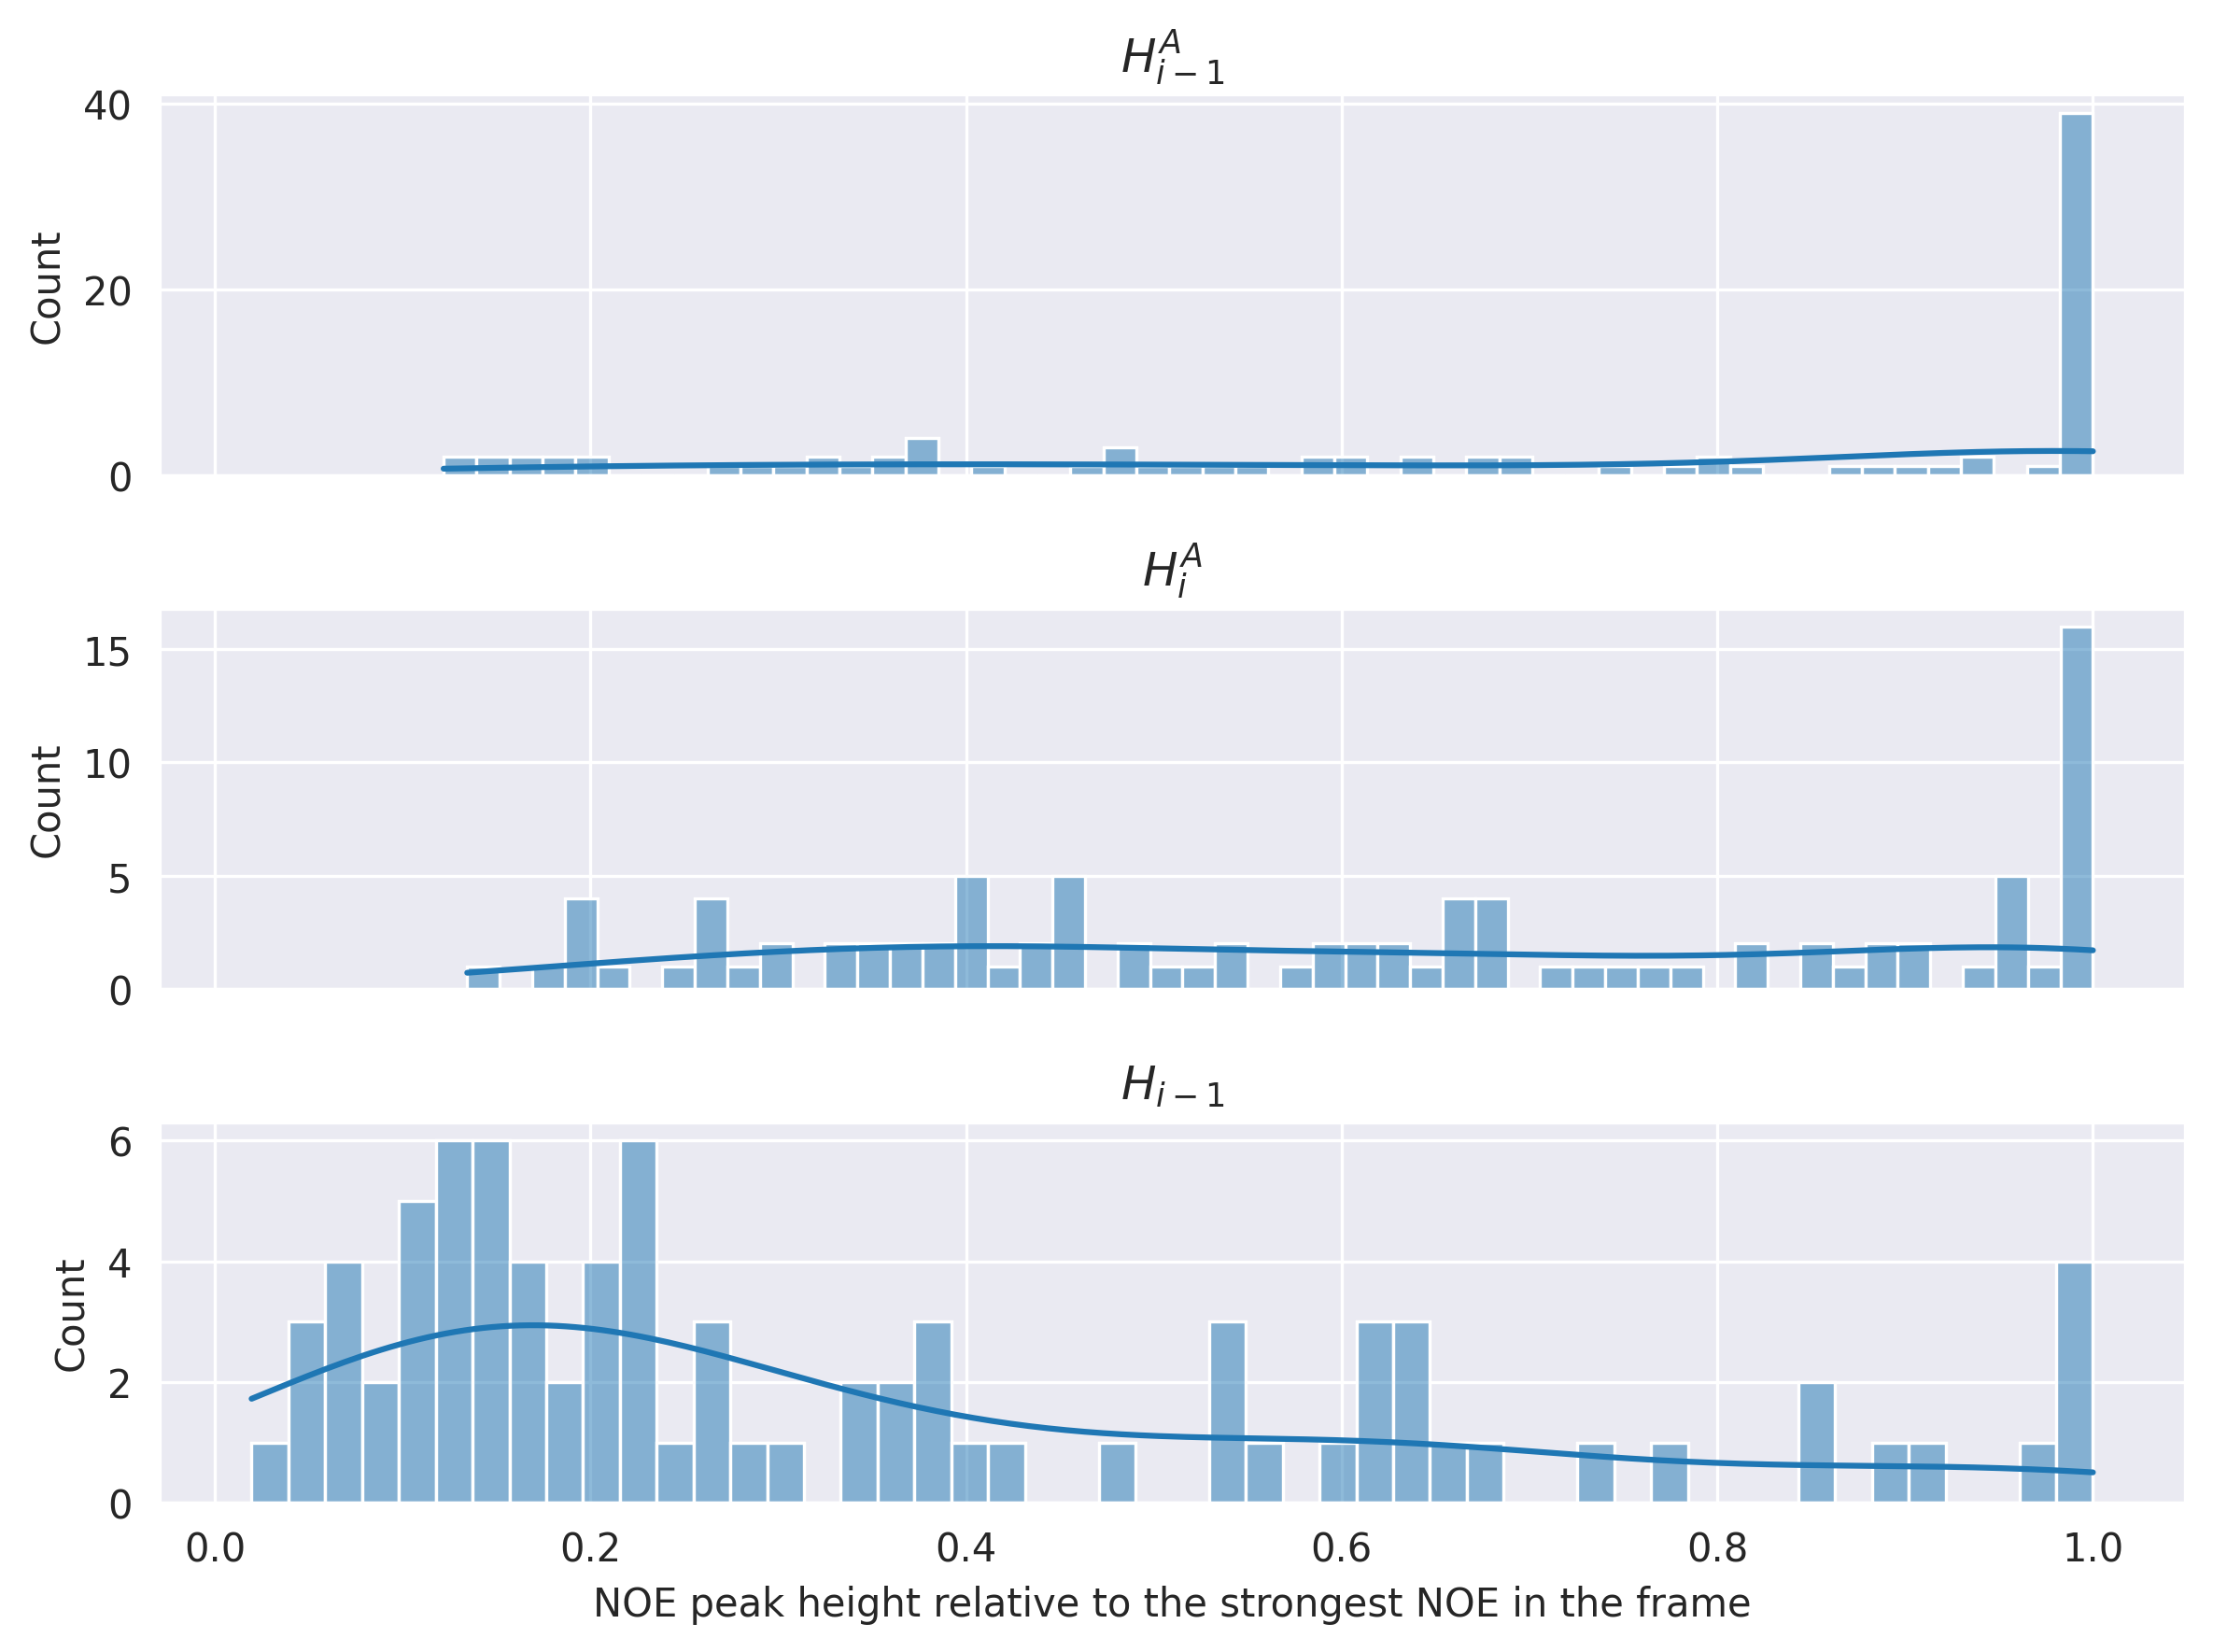

In [160]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,6), sharex=True)
dff_groups = dff_to_plot.groupby('atom_type_pos')

i=0
for gr, data in dff_groups:
    sns.histplot(data=data, x="height", kde=True, bins=50, ax=axs[i])
    axs[i].set_title(gr)
    i+=1
    
plt.xlabel("NOE peak height relative to the strongest NOE in the frame")  
plt.tight_layout()


---

## $H^{i-k}_{\alpha}$

How many $H^{i-k}_{\alpha}$s are stronger than $H^{i}_{\alpha}$?

>Expected from the theory: None. Because any $H^{i-k}_{\alpha}$s are further away from the magnetization source - which is $H^N$ - than $H^{i}_{\alpha}$s

In [15]:
df_intra_Ha = df[~df.inter & df.noe.str.contains('HA')]
df_inter_Ha = df[df.inter & df.noe.str.contains('HA')]

In [16]:
n_anomalies = get_n_anomalies(df_strong=df_intra_Ha,
                              df_weak=df_inter_Ha)

45


For 2LEA, there are 45 cases where an inter-residual NOE is stronger than the very own NOE peak!

In [17]:
# For HAs only:
compare_strongest_noes(df_intra_Ha, df_inter_Ha)

,height_intra,height_inter,noe_resnum
resnum,,,
1,1756,0,0
2,5887,13351,1
3,11348,7299,2
4,8560,28898,3
8,14410,32052,7
...,...,...,...
92,848,631,91
92,457,631,91
93,7823,13397,92
